## **About the Dataset**

JD.com is China’s largest retailer with a net revenue of US$67.2 billion in 2018 and over 320 million annual active customers.

The data sets provided by JD.com capture a “full customer experience cycle” that begins as soon as a customer begins browsing on the platform and ends when the customer receives the delivered products. The data set describes 2.5 million customers (457,298 made purchases) and 30,000 SKUs (from one product category) during the month of March in 2018.

Redference: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3511861


## **Framing the Problem and Question**

JD.com PLUS members benefit from loyalty points, exclusive offers, and discounts, among other perks. Understanding the effect of PLUS membership on spending behavior can help JD.com refine its marketing strategies, pricing, and logistics operations to better serve its customers.

In other words, we want to know how valuable it would be for the company to try to change a user fto a PLUS user.

**Key Question:
What is the effect of PLUS membership on purchase behavior?
Does JD.com’s PLUS membership lead to higher customer spending?**

A recent article states that JD PLUS members spend, on average, 10 times more than non-members, with a 150% increase in annual spending and a 120% boost in shopping frequency.

So, we want to test this hypothesis on a month data. We will focus on monetary spending to see if it is causally driven by PLUS membership itself or influenced by other factors.

Aslo, the data is for one month so any conclusion on this dataset on purchase frequency will not be valid.

Reference: https://retailasia.com/news/jdcom-upgrades-jd-plus-membership-program

## **Causal Inference Model Description**

**Treatment Variable:** Whether a user is a PLUS member (plus).

**Outcome Variable:** Total spending (final_unit_price * quantity).

**Control Variables:** User attributes (user_level, purchase_power, education, marital_status, gender)

## Installing and adding libraries


In [24]:
## Add all the new libraries that you used here
!pip install causalml
!pip install dowhy
!pip install econml
!pip install duecredit

In [25]:
!pip uninstall -y scikit-learn


Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2


In [26]:
!pip install scikit-learn==1.2.2


  Using cached scikit_learn-1.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.6 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.


In [ ]:
%load_ext autoreload
%autoreload 2
from causalml.inference.meta import LRSRegressor

[autoreload of sklearn.base failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.11/dist-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/usr/local/lib/python3.11/dist-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/usr/local/lib/python3.11/dist-packages/IPython/extensions/autoreload.py", line 317, in update_class
    update_instances(old, new)
  File "/usr/local/lib/python3.11/dist-packages/IPython/extensions/autoreload.py", line 276, in update_instances
    refs = gc.get_referrers(old)
           ^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt
]


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost import XGBRegressor
import warnings

from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset import *
from causalml.metrics import *

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

%matplotlib inline


Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.



In [3]:
import importlib
print(importlib.metadata.version('causalml') )

0.15.2


In [35]:
pd.set_option('display.max_columns', 500)

#Loading the JD.com datasets


## Users Table:

| **Field**           | **Data Type** | **Description**                                      | **Sample Value** |
|---------------------|--------------|------------------------------------------------------|------------------|
| `user_ID`          | string       | User unique identification code                     | 000000f736       |
| `user_level`       | int          | User level                                          | 10               |
| `first_order_month` | string       | First month in which the customer placed an order on JD.com (format: yyyy-mm) | 2017-07          |
| `plus`             | int          | If user is with a PLUS membership                   | 0                |
| `gender`           | string       | User gender (estimated)                             | F                |
| `age`              | string       | User age range (estimated)                          | 26-35            |
| `marital_status`   | string       | User marital status (estimated)                     | M                |
| `education`        | int          | User education level (estimated)                    | 3                |
| `purchase_power`   | int          | User purchase power (estimated)                     | 2                |
| `city_level`       | int          | City level of user address                          | 1                |

In [64]:
users_df = pd.read_csv('JD_user_data.csv')
users_df.head()

,user_ID,user_level,first_order_month,plus,gender,age,marital_status,education,city_level,purchase_power
0,000089d6a6,1,2017-08,0,F,26-35,S,3,4,3
1,0000babd1f,1,2018-03,0,U,U,U,-1,-1,-1
2,0000bc018b,3,2016-06,0,F,>=56,M,3,2,3
3,0000d0e5ab,3,2014-06,0,M,26-35,M,3,2,2
4,0000dce472,3,2012-08,1,U,U,U,-1,-1,-1


<Axes: >

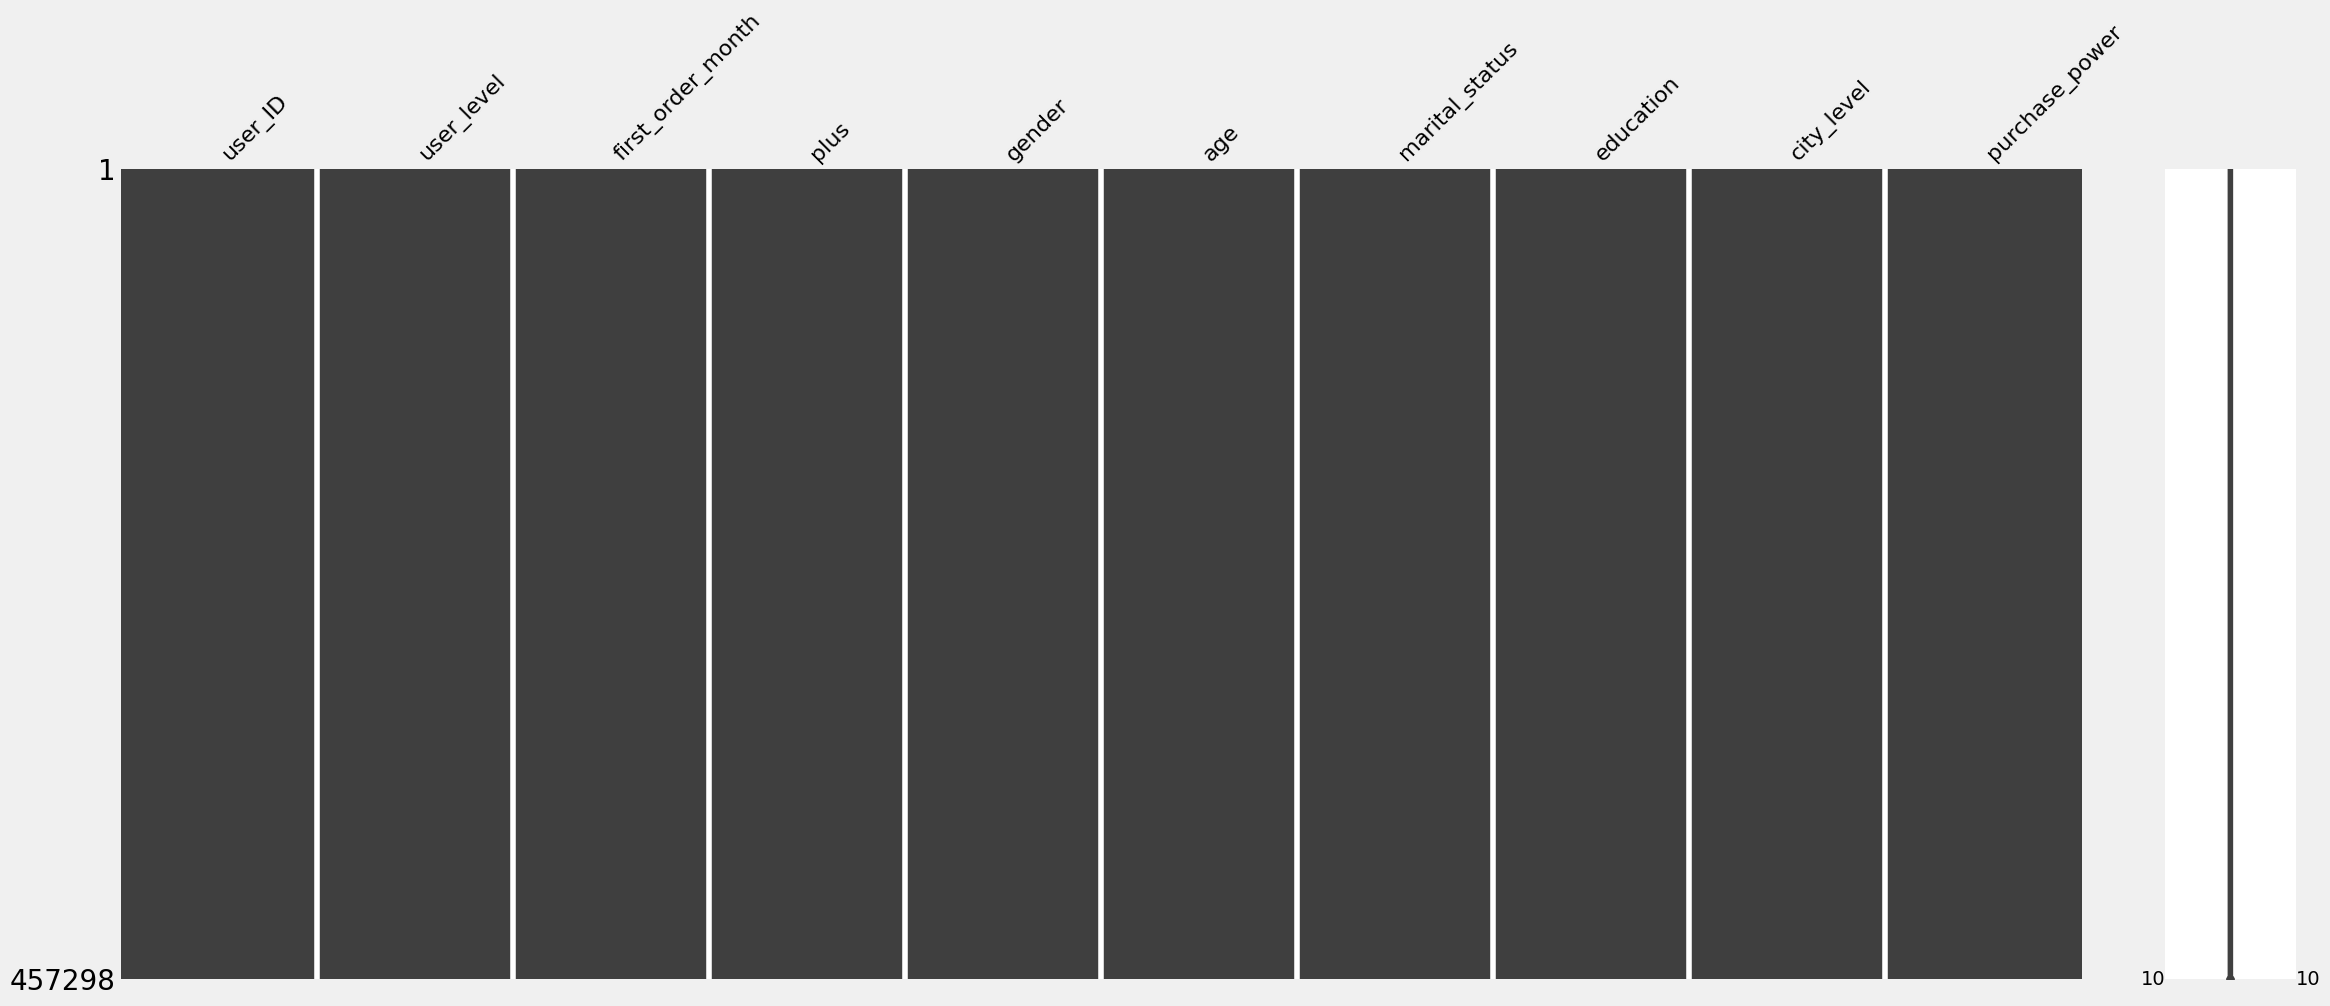

In [65]:
import missingno as msno
msno.matrix(users_df)

In [66]:
users_df.describe()

,user_level,plus,education,city_level,purchase_power
count,457298.000000,457298.000000,457298.000000,457298.000000,457298.000000
mean,2.305547,0.177031,1.938830,1.688945,1.585170
std,1.157647,0.381695,1.752484,1.608057,1.461573
min,-1.000000,0.000000,-1.000000,-1.000000,-1.000000
25%,1.000000,0.000000,1.000000,1.000000,2.000000
50%,2.000000,0.000000,3.000000,2.000000,2.000000
75%,3.000000,0.000000,3.000000,3.000000,2.000000
max,10.000000,1.000000,4.000000,5.000000,5.000000


## Orders Table

| **Field**                    | **Data Type** | **Description**                                                   | **Sample Value**         |
|------------------------------|--------------|-------------------------------------------------------------------|--------------------------|
| `order_ID`                   | string       | Order unique identification code                                  | 3b76bfcd3b               |
| `user_ID`                    | string       | User unique identification code                                   | 3cde601074               |
| `sku_ID`                     | string       | SKU unique identification code                                   | 443fd601f0               |
| `order_date`                 | string       | Order date (format: yyyy-mm-dd)                                  | 2018-03-01               |
| `order_time`                 | string       | Specific time at which the order was placed (format: yyyy-mm-dd HH:MM:SS) | 2018-03-01 11:10:40.0 |
| `quantity`                   | int          | Number of units ordered                                          | 1                        |
| `type`                       | int          | 1P or 3P orders                                                 | 1                        |
| `promise`                    | int          | Expected delivery time (in days)                                | 2                        |
| `original_unit_price`        | float        | Original list price                                             | 99.9                     |
| `final_unit_price`           | float        | Final purchase price                                            | 53.9                     |
| `direct_discount_per_unit`   | float        | Discount due to SKU direct discount                             | 5.0                      |
| `quantity_discount_per_unit` | float        | Discount due to purchase quantity                               | 41.0                      |
| `bundle_discount_per_unit`   | float        | Discount due to “bundle promotion”                              | 0.0                      |
| `coupon_discount_per_unit`   | float        | Discount due to customer coupon                                 | 0.0                      |
| `gift_item`                  | int          | If the SKU is part of a gift promotion                         | 0                        |
| `dc_ori`                     | int          | Distribution center ID where the order is shipped from         | 29                       |
| `dc_des`                     | int          | Destination address where the order is shipped to (closest DC ID) | 29                       |


In [67]:
#Read Orders table
orders_df = pd.read_csv('JD_order_data.csv')
orders_df.head()

,order_ID,user_ID,sku_ID,order_date,order_time,quantity,type,promise,original_unit_price,final_unit_price,direct_discount_per_unit,quantity_discount_per_unit,bundle_discount_per_unit,coupon_discount_per_unit,gift_item,dc_ori,dc_des
0,d0cf5cc6db,0abe9ef2ce,581d5b54c1,2018-03-01,2018-03-01 17:14:25.0,1,2,-,89.0,79.0,0.0,10.0,0.0,0.0,0,4,28
1,7444318d01,33a9e56257,067b673f2b,2018-03-01,2018-03-01 11:10:40.0,1,1,2,99.9,53.9,5.0,41.0,0.0,0.0,0,28,28
2,f973b01694,4ea3cf408f,623d0a582a,2018-03-01,2018-03-01 09:13:26.0,1,1,2,78.0,58.5,19.5,0.0,0.0,0.0,0,28,28
3,8c1cec8d4b,b87cb736cb,fc5289b139,2018-03-01,2018-03-01 21:29:50.0,1,1,2,61.0,35.0,0.0,26.0,0.0,0.0,0,4,28
4,d43a33c38a,4829223b6f,623d0a582a,2018-03-01,2018-03-01 19:13:37.0,1,1,1,78.0,53.0,19.0,0.0,0.0,6.0,0,3,16


<Axes: >

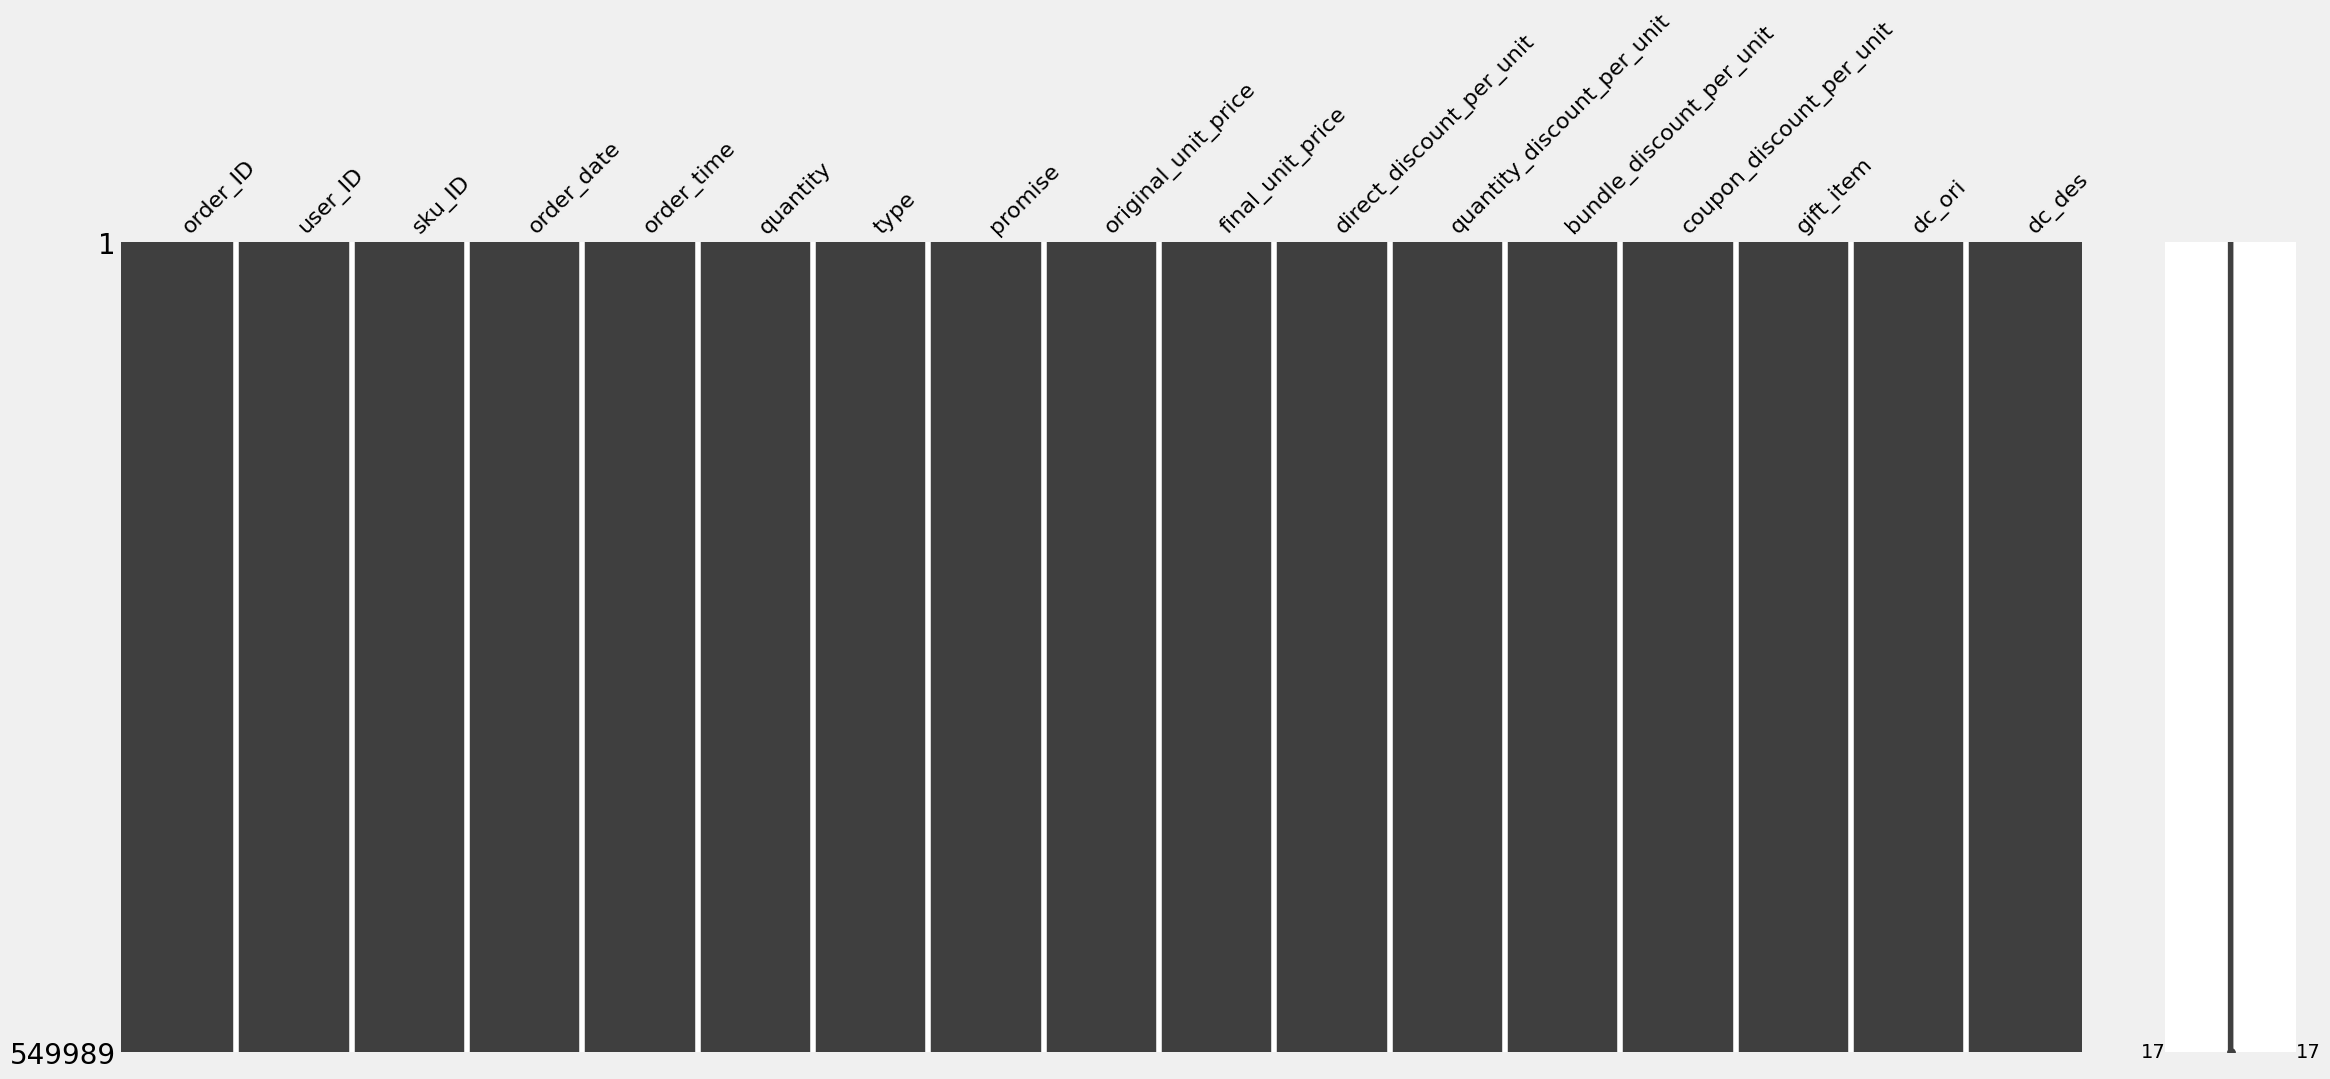

In [8]:
import missingno as msno
msno.matrix(orders_df)

In [68]:
#Add a new Column for Total Soending (Since each row is for a SKU, this would be also SKU Level)
orders_df['total_spending'] = orders_df['quantity'] * orders_df['final_unit_price']
orders_df.describe()

,quantity,type,original_unit_price,final_unit_price,direct_discount_per_unit,quantity_discount_per_unit,bundle_discount_per_unit,coupon_discount_per_unit,gift_item,dc_ori,dc_des,total_spending
count,549989.000000,549989.000000,549989.000000,549989.000000,549989.000000,549989.000000,549989.000000,549989.000000,549989.000000,549989.000000,549989.000000,549989.000000
mean,1.216670,1.499139,102.813542,71.572599,19.845889,7.843390,0.625649,2.926015,0.172014,12.062714,21.679845,82.798985
std,1.844589,0.500000,95.035563,75.879057,33.593536,17.994354,6.442281,11.588338,0.377393,14.201200,16.973899,219.327262
min,1.000000,1.000000,0.000000,-32.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,-34.000000
25%,1.000000,1.000000,59.000000,33.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,5.000000,35.000000
50%,1.000000,1.000000,79.000000,58.000000,4.000000,0.000000,0.000000,0.000000,0.000000,7.000000,20.000000,62.000000
75%,1.000000,2.000000,139.000000,95.000000,21.000000,0.000000,0.000000,0.000000,0.000000,10.000000,34.000000,109.000000
max,400.000000,2.000000,12158.000000,12158.000000,720.000000,225.000000,252.000000,210.000000,1.000000,67.000000,67.000000,73008.000000


We see that final_unit price is negative for many gift Items.
In the data description file it is mentioned: The final_unit_price for each gift item is always equal to 0.

On the other hand, Our analysis is on the money spent by Plus members so gifts will not contribute to that.
So we drop all gifts and check the stats again

In [69]:
#Keep gift Items out of the analysis
orders_df_clean = orders_df[orders_df['gift_item'] == 0]
orders_df_clean.describe()

,quantity,type,original_unit_price,final_unit_price,direct_discount_per_unit,quantity_discount_per_unit,bundle_discount_per_unit,coupon_discount_per_unit,gift_item,dc_ori,dc_des,total_spending
count,455383.000000,455383.000000,455383.000000,4.553830e+05,455383.000000,455383.000000,455383.000000,455383.000000,455383.0,455383.000000,455383.000000,4.553830e+05
mean,1.208128,1.431140,124.172196,8.648655e+01,23.967981,9.440013,0.755628,3.522023,0.0,12.951443,21.620451,1.000626e+02
std,1.945796,0.495236,90.862467,7.523602e+01,35.554686,19.393426,7.072981,12.651505,0.0,15.115292,16.982503,2.374135e+02
min,1.000000,1.000000,0.005000,7.105427e-15,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,1.000000,7.105427e-15
25%,1.000000,1.000000,69.000000,4.550000e+01,0.000000,0.000000,0.000000,0.000000,0.0,4.000000,5.000000,4.900000e+01
50%,1.000000,1.000000,89.000000,6.590000e+01,10.000000,0.000000,0.000000,0.000000,0.0,7.000000,20.000000,6.990000e+01
75%,1.000000,2.000000,150.000000,1.080000e+02,30.000000,8.580000,0.000000,0.000000,0.0,10.000000,34.000000,1.260000e+02
max,400.000000,2.000000,12158.000000,1.215800e+04,720.000000,225.000000,252.000000,210.000000,0.0,67.000000,67.000000,7.300800e+04


In [70]:
orders_df.shape, orders_df_clean.shape

((549989, 18), (455383, 18))

In [76]:
#Merge Users and Orders, bring the users data to orders table
JD_df = pd.merge(orders_df_clean, users_df, on='user_ID', how='right')
JD_df.describe()

,quantity,type,original_unit_price,final_unit_price,direct_discount_per_unit,quantity_discount_per_unit,bundle_discount_per_unit,coupon_discount_per_unit,gift_item,dc_ori,dc_des,total_spending,user_level,plus,education,city_level,purchase_power
count,455383.000000,455383.000000,455383.000000,4.553830e+05,455383.000000,455383.000000,455383.000000,455383.000000,455383.0,455383.000000,455383.000000,4.553830e+05,508793.000000,508793.000000,508793.000000,508793.000000,508793.000000
mean,1.208128,1.431140,124.172196,8.648655e+01,23.967981,9.440013,0.755628,3.522023,0.0,12.951443,21.620451,1.000626e+02,2.406719,0.185720,1.961926,1.673746,1.584713
std,1.945796,0.495236,90.862467,7.523602e+01,35.554686,19.393426,7.072981,12.651505,0.0,15.115292,16.982503,2.374135e+02,1.355995,0.388881,1.754217,1.609759,1.454900
min,1.000000,1.000000,0.005000,7.105427e-15,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,1.000000,7.105427e-15,-1.000000,0.000000,-1.000000,-1.000000,-1.000000
25%,1.000000,1.000000,69.000000,4.550000e+01,0.000000,0.000000,0.000000,0.000000,0.0,4.000000,5.000000,4.900000e+01,1.000000,0.000000,1.000000,1.000000,2.000000
50%,1.000000,1.000000,89.000000,6.590000e+01,10.000000,0.000000,0.000000,0.000000,0.0,7.000000,20.000000,6.990000e+01,2.000000,0.000000,3.000000,2.000000,2.000000
75%,1.000000,2.000000,150.000000,1.080000e+02,30.000000,8.580000,0.000000,0.000000,0.0,10.000000,34.000000,1.260000e+02,3.000000,0.000000,3.000000,3.000000,2.000000
max,400.000000,2.000000,12158.000000,1.215800e+04,720.000000,225.000000,252.000000,210.000000,0.0,67.000000,67.000000,7.300800e+04,10.000000,1.000000,4.000000,5.000000,5.000000


In [77]:
print(JD_df['total_spending'].isna().sum())  # Check if there are NaNs
print(JD_df[JD_df['total_spending'] == 0].shape[0])  # Count zero spending users


53410
0


<Axes: >

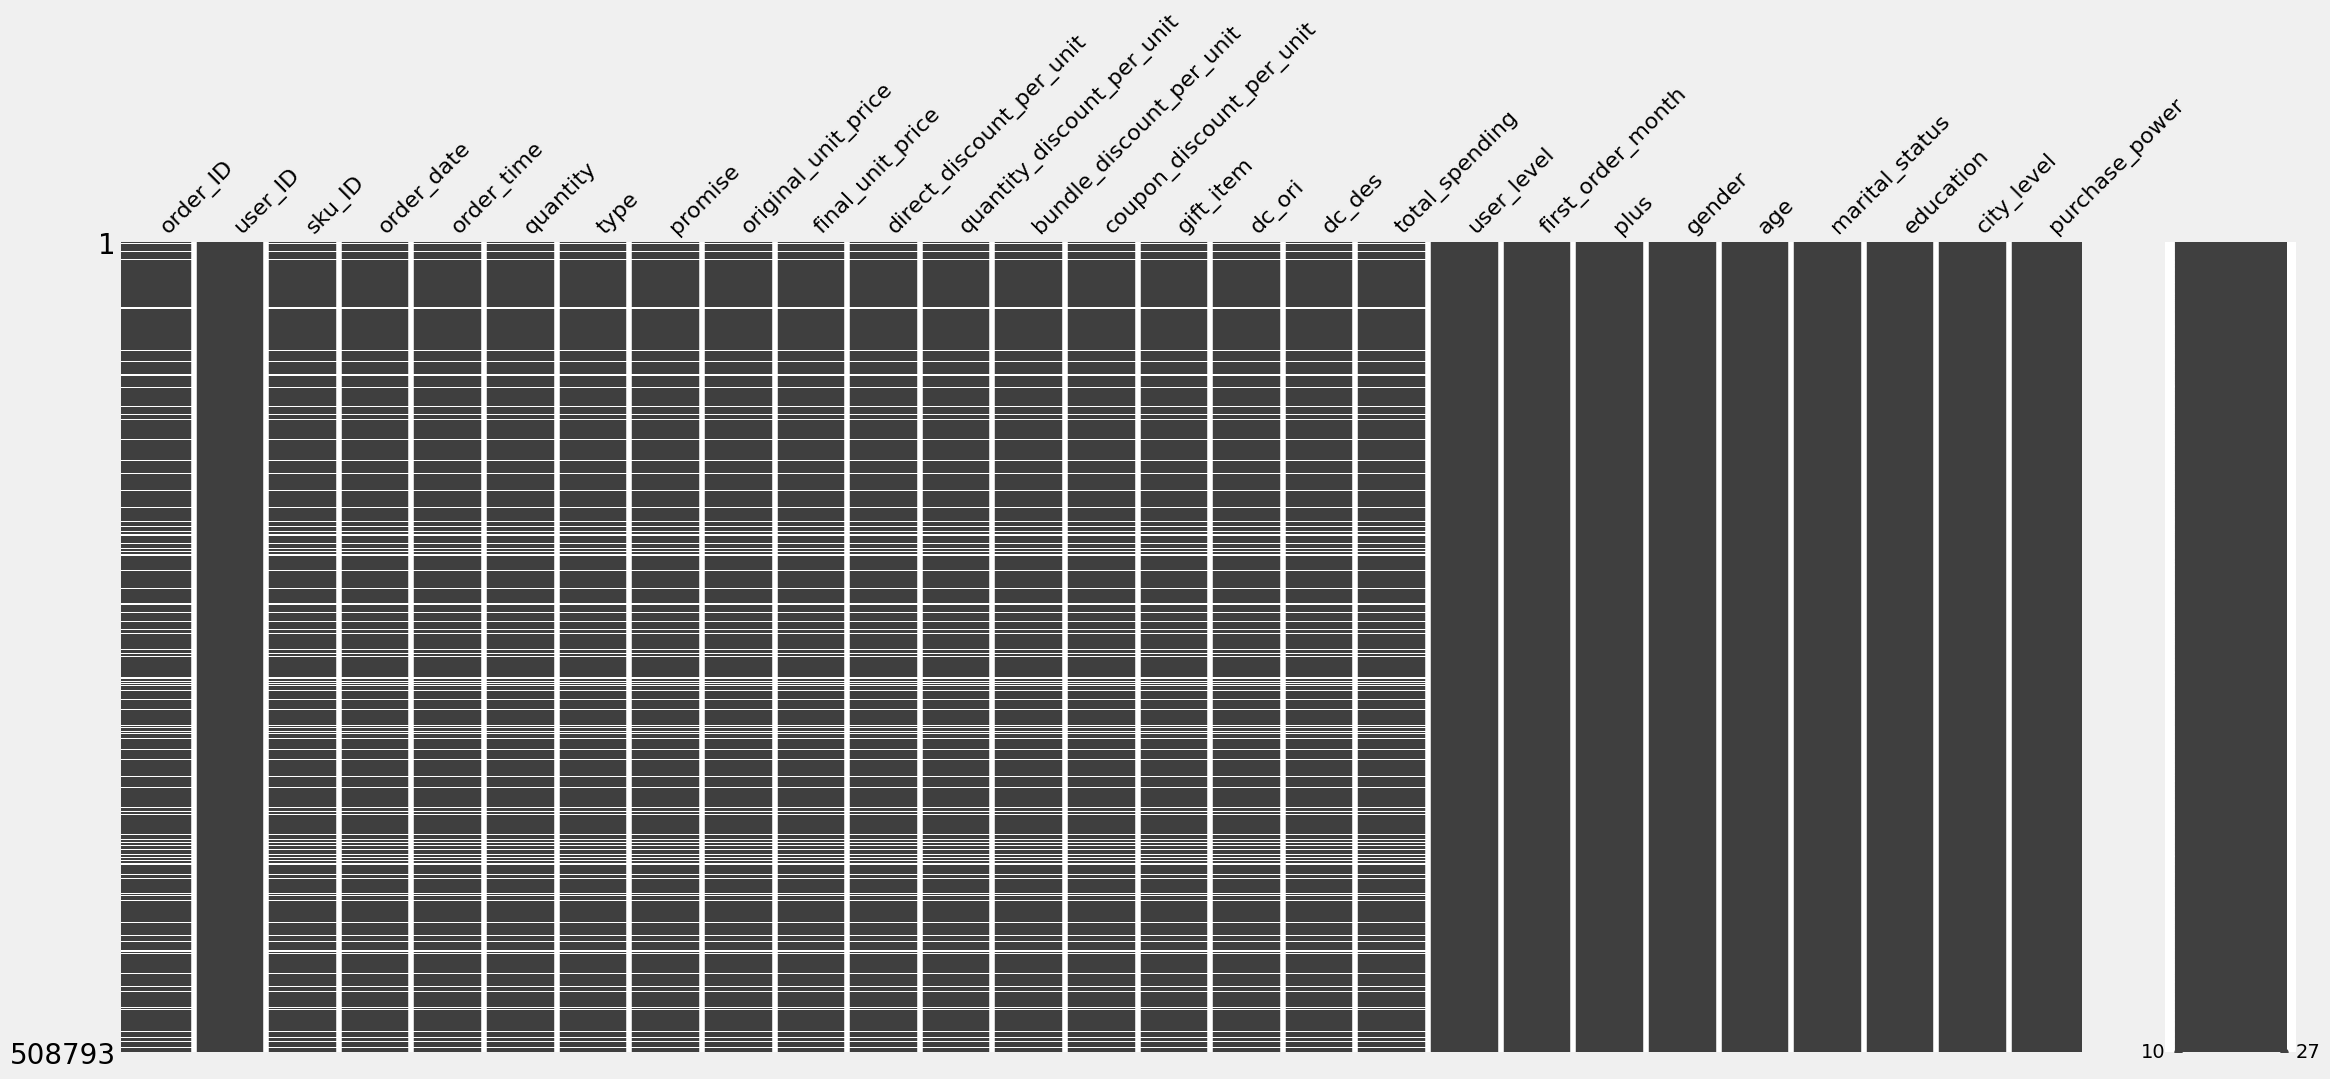

In [78]:
import missingno as msno
msno.matrix(JD_df)

In [79]:
    JD_df['total_spending'] = JD_df['total_spending'].fillna(0)
    JD_df.describe()

,quantity,type,original_unit_price,final_unit_price,direct_discount_per_unit,quantity_discount_per_unit,bundle_discount_per_unit,coupon_discount_per_unit,gift_item,dc_ori,dc_des,total_spending,user_level,plus,education,city_level,purchase_power
count,455383.000000,455383.000000,455383.000000,4.553830e+05,455383.000000,455383.000000,455383.000000,455383.000000,455383.0,455383.000000,455383.000000,508793.000000,508793.000000,508793.000000,508793.000000,508793.000000,508793.000000
mean,1.208128,1.431140,124.172196,8.648655e+01,23.967981,9.440013,0.755628,3.522023,0.0,12.951443,21.620451,89.558623,2.406719,0.185720,1.961926,1.673746,1.584713
std,1.945796,0.495236,90.862467,7.523602e+01,35.554686,19.393426,7.072981,12.651505,0.0,15.115292,16.982503,226.691457,1.355995,0.388881,1.754217,1.609759,1.454900
min,1.000000,1.000000,0.005000,7.105427e-15,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,1.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000
25%,1.000000,1.000000,69.000000,4.550000e+01,0.000000,0.000000,0.000000,0.000000,0.0,4.000000,5.000000,40.000000,1.000000,0.000000,1.000000,1.000000,2.000000
50%,1.000000,1.000000,89.000000,6.590000e+01,10.000000,0.000000,0.000000,0.000000,0.0,7.000000,20.000000,68.000000,2.000000,0.000000,3.000000,2.000000,2.000000
75%,1.000000,2.000000,150.000000,1.080000e+02,30.000000,8.580000,0.000000,0.000000,0.0,10.000000,34.000000,118.000000,3.000000,0.000000,3.000000,3.000000,2.000000
max,400.000000,2.000000,12158.000000,1.215800e+04,720.000000,225.000000,252.000000,210.000000,0.0,67.000000,67.000000,73008.000000,10.000000,1.000000,4.000000,5.000000,5.000000


In [12]:
JD_df.columns

Index(['order_ID', 'user_ID', 'sku_ID', 'order_date', 'order_time', 'quantity',
       'type', 'promise', 'original_unit_price', 'final_unit_price',
       'direct_discount_per_unit', 'quantity_discount_per_unit',
       'bundle_discount_per_unit', 'coupon_discount_per_unit', 'gift_item',
       'dc_ori', 'dc_des', 'total_spending', 'user_level', 'first_order_month',
       'plus', 'gender', 'age', 'marital_status', 'education', 'city_level',
       'purchase_power'],
      dtype='object')

#Aggregate the data and do some EDA

Here, we will aggregate on user level to calculate the total spending in March and continue the analysis for being a PLUS member as treatment and users' charactristics as Confounders.

In [111]:
# Aggregate the data to user level
JD_user_level = JD_df.groupby("user_ID").agg(
    total_spending=pd.NamedAgg(column="total_spending", aggfunc="sum"),
    user_level=pd.NamedAgg(column="user_level", aggfunc="first"),
    purchase_power=pd.NamedAgg(column="purchase_power", aggfunc="first"),
    education=pd.NamedAgg(column="education", aggfunc="first"),
    gender=pd.NamedAgg(column="gender", aggfunc="first"),
    marital_status=pd.NamedAgg(column="marital_status", aggfunc="first"),
    plus=pd.NamedAgg(column="plus", aggfunc="first")  # Treatment variable
).reset_index()

JD_user_level.head()


,user_ID,total_spending,user_level,purchase_power,education,gender,marital_status,plus
0,000089d6a6,215.0,1,3,3,F,S,0
1,0000babd1f,39.0,1,-1,-1,U,U,0
2,0000bc018b,79.0,3,3,3,F,M,0
3,0000d0e5ab,228.0,3,2,3,M,M,0
4,0000dce472,111.5,3,-1,-1,U,U,1


In [81]:
#High level view
print(JD_user_level.describe())
print(JD_user_level.info())

       total_spending     user_level  purchase_power      education  \
count   457298.000000  457298.000000   457298.000000  457298.000000   
mean        99.643560       2.305547        1.585170       1.938830   
std        450.913328       1.157647        1.461573       1.752484   
min          0.000000      -1.000000       -1.000000      -1.000000   
25%         42.000000       1.000000        2.000000       1.000000   
50%         69.000000       2.000000        2.000000       3.000000   
75%        125.000000       3.000000        2.000000       3.000000   
max     212088.240000      10.000000        5.000000       4.000000   

                plus  
count  457298.000000  
mean        0.177031  
std         0.381695  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 457298 entries, 0 to 457297
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype

In [112]:
# Unique values per categorical variable
print(JD_user_level[['gender', 'marital_status', 'plus']].nunique())

#See unique values
print(JD_user_level['gender'].unique())
print(JD_user_level['marital_status'].unique())

#U id for Undefined

gender            3
marital_status    3
plus              2
dtype: int64
['F' 'U' 'M']
['S' 'U' 'M']


## Analyzing Target variable distribution

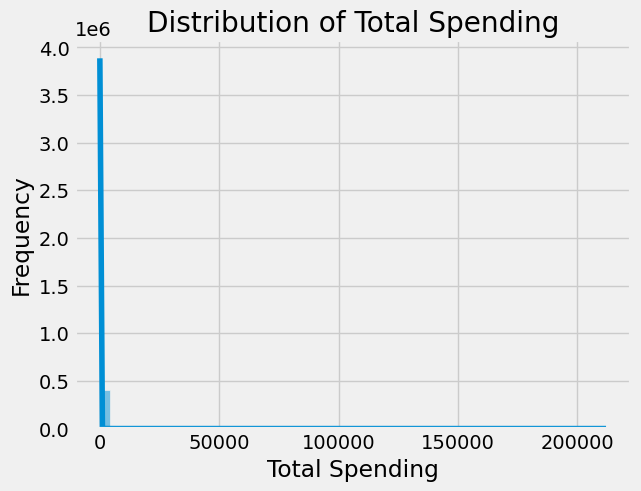

In [17]:
# Plot distribution of total spending

import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(JD_user_level['total_spending'], bins=50, kde=True)
plt.title("Distribution of Total Spending")
plt.xlabel("Total Spending")
plt.ylabel("Frequency")
plt.show()


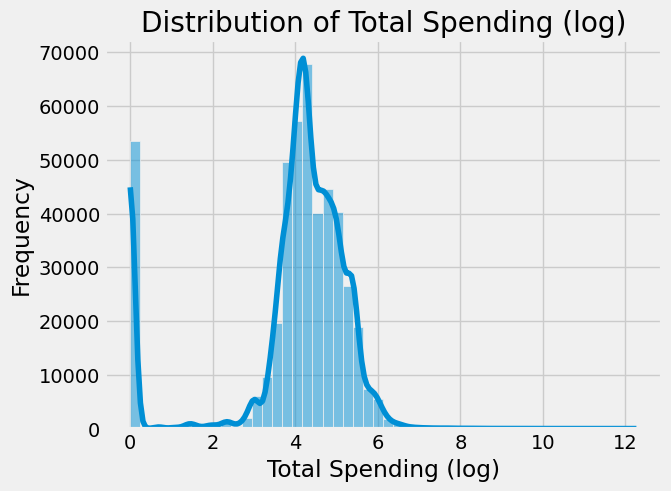

In [113]:
#The spending is highly skewed so we add log transformation to have a more clear distribution
JD_user_level['log_total_spending'] = np.log1p(JD_user_level['total_spending'])

#Distribution after log transformation
sns.histplot(JD_user_level['log_total_spending'], bins=50, kde=True)
plt.title("Distribution of Total Spending (log)")
plt.xlabel("Total Spending (log)")
plt.ylabel("Frequency")
plt.show()


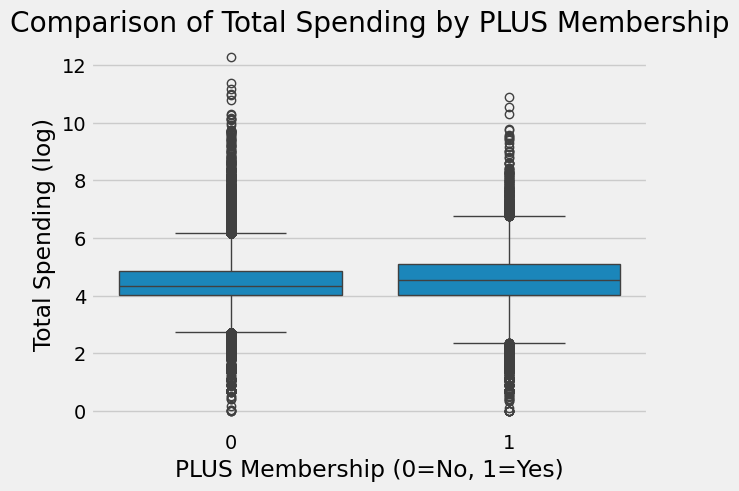

In [27]:
#Compare Plus vs non-Plus total spending
sns.boxplot(x="plus", y="log_total_spending", data=JD_user_level)
plt.title("Comparison of Total Spending by PLUS Membership")
plt.xlabel("PLUS Membership (0=No, 1=Yes)")
plt.ylabel("Total Spending (log)")
plt.show()

## Looking at distribution and boxplot after removing zeros (Meaning, we will only keep users that did place an order at least once that month)
**All distributions stay quite the same as expected.**

In [114]:
#Remove all zero total spendings (and their corresponding userts)
JD_user_level_clean = JD_user_level[JD_user_level['total_spending'] > 0]

print(JD_user_level.shape, JD_user_level_clean.shape)

(457298, 9) (403888, 9)


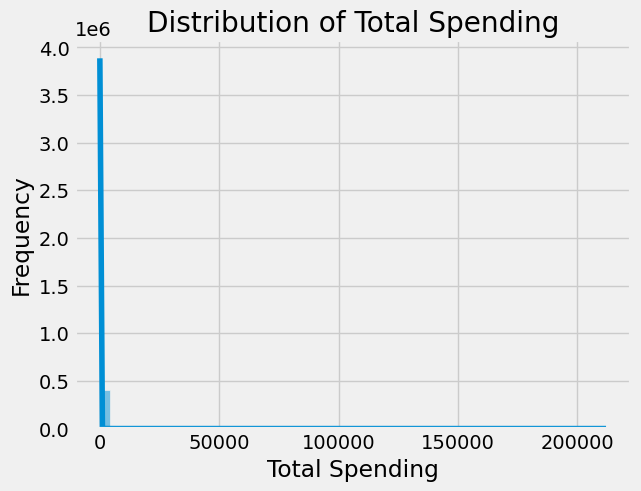

In [83]:
#The distribution without log will stay quite similar since we have many small orders
sns.histplot(JD_user_level_clean['total_spending'], bins=50, kde=True)
plt.title("Distribution of Total Spending")
plt.xlabel("Total Spending")
plt.ylabel("Frequency")
plt.show()


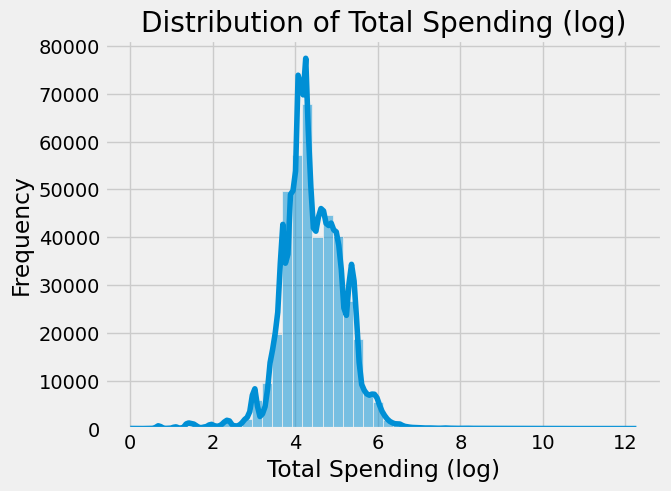

In [115]:
#Log transfomation on total spending after removing zeros
JD_user_level_clean['log_total_spending'] = np.log1p(JD_user_level_clean['total_spending'])

#Distribution after log transformation
sns.histplot(JD_user_level_clean['log_total_spending'], bins=50, kde=True)
plt.title("Distribution of Total Spending (log)")
plt.xlabel("Total Spending (log)")
plt.ylabel("Frequency")
plt.show()

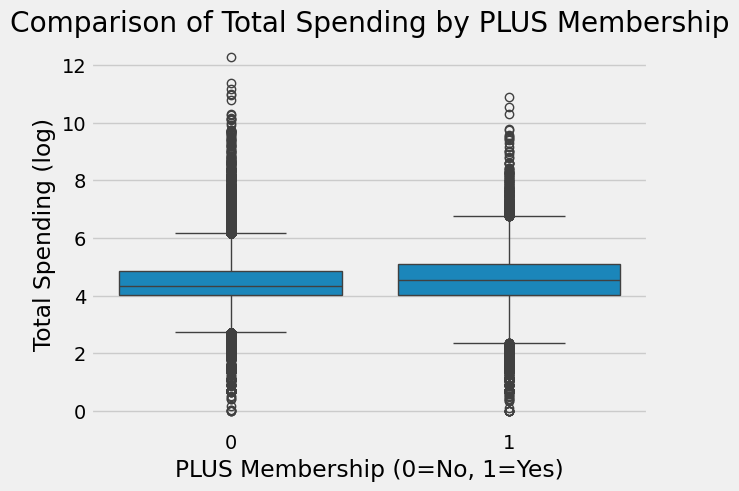

In [85]:
#Compare Plus vs non-Plus total spending after removing zeros
sns.boxplot(x="plus", y="log_total_spending", data=JD_user_level_clean)
plt.title("Comparison of Total Spending by PLUS Membership")
plt.xlabel("PLUS Membership (0=No, 1=Yes)")
plt.ylabel("Total Spending (log)")
plt.show()

## Checking boxplot of Target by Control Variables

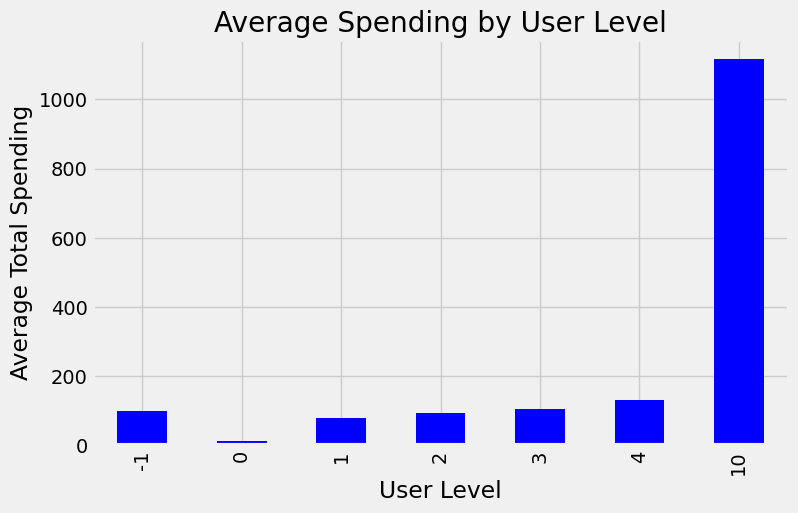

In [86]:
JD_user_level.groupby("user_level")["total_spending"].mean().plot(kind="bar", color="blue", figsize=(8,5))
plt.title("Average Spending by User Level")
plt.xlabel("User Level")
plt.ylabel("Average Total Spending")
plt.show()


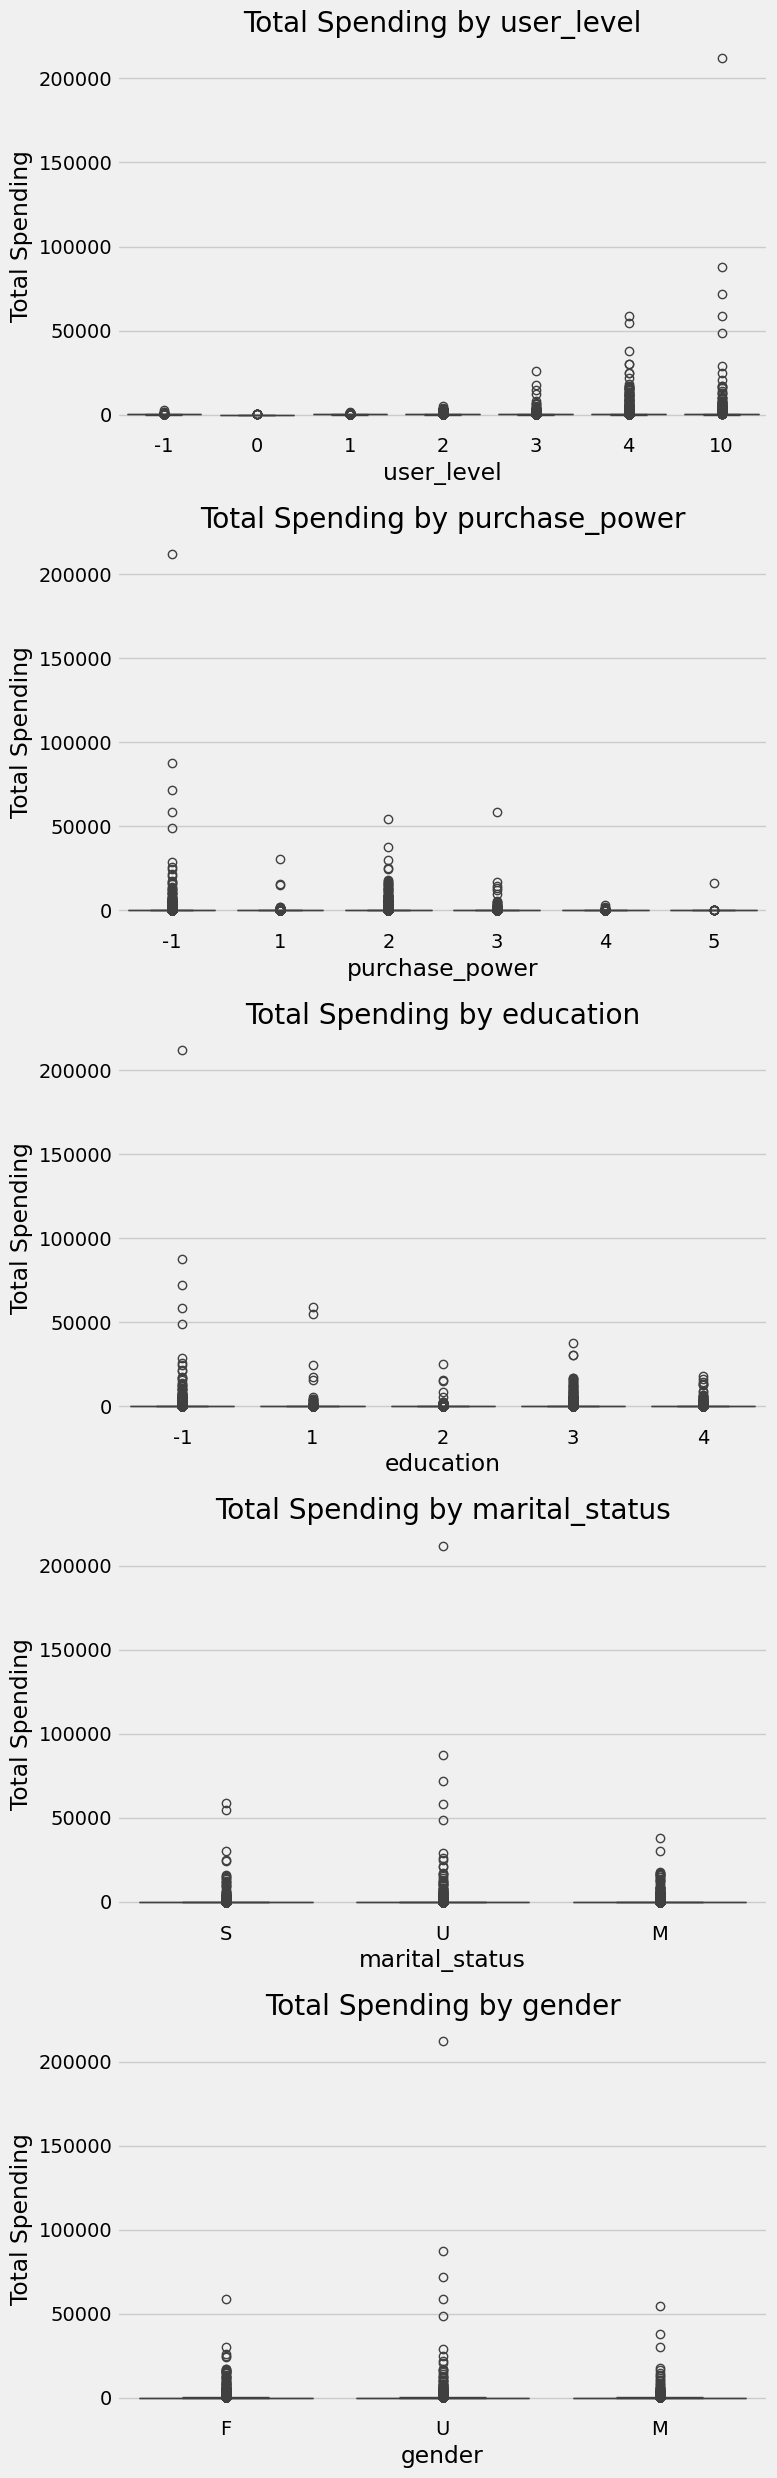

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define control variables (confounders)
controls = ["user_level", "purchase_power", "education", "marital_status", "gender"]

# Set up subplots (one per row)
fig, axes = plt.subplots(nrows=len(controls), ncols=1, figsize=(8, 5 * len(controls)))  # Adjust height dynamically

# Create boxplots for each confounder in a separate row
for i, control in enumerate(controls):
    sns.boxplot(x=JD_user_level[control], y=JD_user_level["total_spending"], ax=axes[i])
    axes[i].set_title(f"Total Spending by {control}")
    axes[i].set_xlabel(control)
    axes[i].set_ylabel("Total Spending")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


Comparing Zeros among Plus and non-Plus users

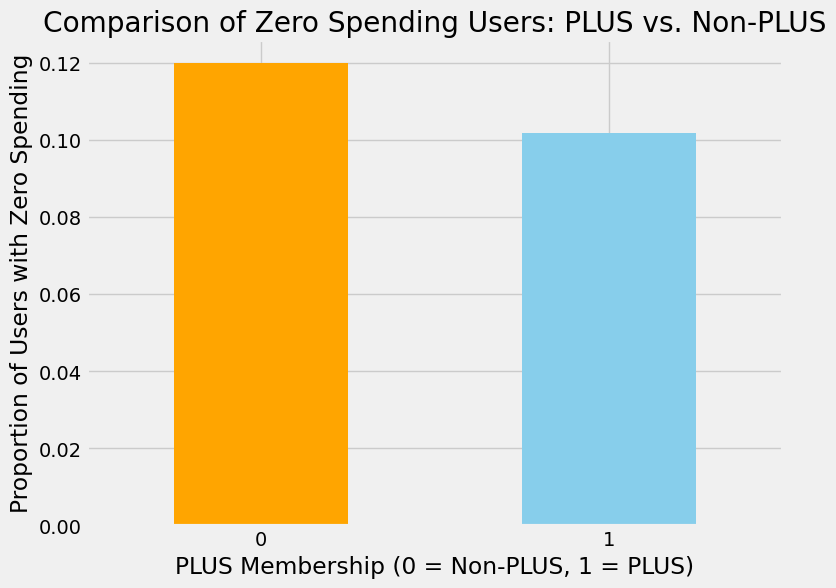

In [136]:
import pandas as pd
import matplotlib.pyplot as plt

# Count the number of users with zero total spending in each group
zero_spending_counts = JD_user_level.groupby("plus")["total_spending"].apply(lambda x: (x == 0).sum())

# Count total users in each group
total_users = JD_user_level["plus"].value_counts()

# Calculate the proportion of users with zero spending
zero_spending_proportion = zero_spending_counts / total_users

# Convert to DataFrame for easier visualization
zero_spending_df = pd.DataFrame({
    "Total Users": total_users,
    "Zero Spending Users": zero_spending_counts,
    "Proportion Zero Spending": zero_spending_proportion
})

zero_spending_df

# Plot the proportion of users with zero spending
plt.figure(figsize=(8, 6))
zero_spending_proportion.plot(kind="bar", color=["orange", "skyblue"])
plt.xlabel("PLUS Membership (0 = Non-PLUS, 1 = PLUS)")
plt.ylabel("Proportion of Users with Zero Spending")
plt.title("Comparison of Zero Spending Users: PLUS vs. Non-PLUS")
plt.xticks(rotation=0)
plt.show()


**Interpretation:**

The difference in zero spending proportion between PLUS and Non-PLUS users is not significant.

Since the proportion of zero-spending users is similar in both groups, our dataset is fairly balanced in terms of user inactivity.

# **Causal Inference Code_User Level**



##Using DoWhy on complete data (including in-active users)

In [37]:
from dowhy import CausalModel
from causalml.inference.meta import BaseXRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [50]:
JD_user_level

,user_ID,total_spending,user_level,purchase_power,education,gender,marital_status,plus,propensity_score
0,000089d6a6,215.0,1,3,3,F,S,0,0.038090
1,0000babd1f,39.0,1,-1,-1,U,U,0,0.019564
2,0000bc018b,79.0,3,3,3,F,M,0,0.190949
3,0000d0e5ab,228.0,3,2,3,M,M,0,0.366504
4,0000dce472,111.5,3,-1,-1,U,U,1,0.080725
...,...,...,...,...,...,...,...,...,...
403883,ffff03373a,44.9,2,2,3,F,S,0,0.104993
403884,ffff0b5ecd,129.0,1,3,3,F,M,0,0.050901
403885,ffff38690b,237.0,1,-1,-1,U,U,0,0.019564
403886,ffffb20ef7,59.0,3,2,2,M,M,0,0.224427


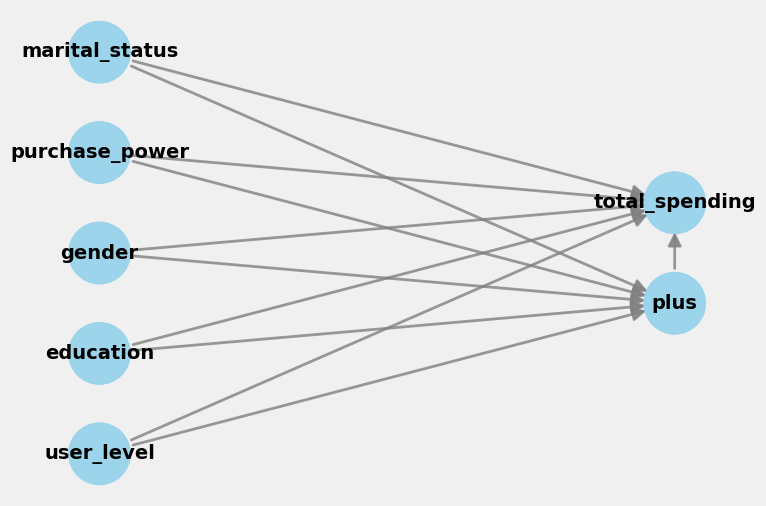

In [101]:
# Define the causal model
model = CausalModel(
    data=JD_user_level,
    treatment="plus",  # Treatment variable
    outcome="total_spending",  # Outcome variable
    common_causes=["user_level", "purchase_power", "education", "gender", "marital_status"]  # Control variables
)

# View the causal model
model.view_model()


In [102]:
#Identify the causal effect
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                                
───────(E[total_spending|user_level,education,gender,purchase_power,marital_status])
d[plus]                                                                             
Estimand assumption 1, Unconfoundedness: If U→{plus} and U→total_spending then P(total_spending|plus,user_level,education,gender,purchase_power,marital_status,U) = P(total_spending|plus,user_level,education,gender,purchase_power,marital_status)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



###**Interpretation:**
The output confirms that we can estimate the causal effect of PLUS membership on total spending using the backdoor adjustment method, meaning we control for variables like user level, education, gender, purchase power, and marital status to remove bias.

However, the model did not find valid instrumental variables (IVs) or frontdoor paths, meaning there are no external factors or mediators that could independently influence PLUS membership and spending.

This means we can proceed with estimating the causal effect using Propensity Score Matching (PSM).

In [93]:
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_matching"
)
print(f"Estimated Causal Effect: {estimate.value}")


Estimated Causal Effect: 25.96529383465486


##**Next Step:** Experimenting with Different Meta-Learners

* LRSRegressor (S-Learner) → A simple linear regression-based model.

* XGBTRegressor (T-Learner) → A more powerful tree-based model (XGBoost) that captures non-linear relationships.


In [116]:
#Handle Categorical Values
JD_user_level.info()

# Apply One-Hot Encoding but keep "U" as the baseline group
JD_user_level = pd.get_dummies(JD_user_level, columns=["gender", "marital_status"], drop_first=False)

# Drop 'U' dummy columns, keeping them as the reference group
JD_user_level = JD_user_level.drop(columns=["gender_U", "marital_status_U"])

JD_user_level.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 457298 entries, 0 to 457297
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   user_ID             457298 non-null  object 
 1   total_spending      457298 non-null  float64
 2   user_level          457298 non-null  int64  
 3   purchase_power      457298 non-null  int64  
 4   education           457298 non-null  int64  
 5   gender              457298 non-null  object 
 6   marital_status      457298 non-null  object 
 7   plus                457298 non-null  int64  
 8   log_total_spending  457298 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 31.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 457298 entries, 0 to 457297
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   user_ID             457298 non-null  object 
 1   total_spend

In [117]:
#Drop user_ID column
JD_user_level = JD_user_level.drop(columns=["user_ID"])
JD_user_level.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 457298 entries, 0 to 457297
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   total_spending      457298 non-null  float64
 1   user_level          457298 non-null  int64  
 2   purchase_power      457298 non-null  int64  
 3   education           457298 non-null  int64  
 4   plus                457298 non-null  int64  
 5   log_total_spending  457298 non-null  float64
 6   gender_F            457298 non-null  bool   
 7   gender_M            457298 non-null  bool   
 8   marital_status_M    457298 non-null  bool   
 9   marital_status_S    457298 non-null  bool   
dtypes: bool(4), float64(2), int64(4)
memory usage: 22.7 MB


In [105]:
JD_user_level.head()

,user_ID,total_spending,user_level,purchase_power,education,gender,marital_status,plus,propensity_score
0,000089d6a6,215.0,1,3,3,F,S,0,0.037058
1,0000babd1f,39.0,1,-1,-1,U,U,0,0.019061
2,0000bc018b,79.0,3,3,3,F,M,0,0.189800
3,0000d0e5ab,228.0,3,2,3,M,M,0,0.358018
4,0000dce472,111.5,3,-1,-1,U,U,1,0.080761


In [120]:
# Check for missing values in the dataset
print(JD_user_level[features].isna().sum())

# Check data types of the features
print(JD_user_level[features].dtypes)


user_level          0
purchase_power      0
education           0
gender_M            0
gender_F            0
marital_status_S    0
marital_status_M    0
dtype: int64
user_level          int64
purchase_power      int64
education           int64
gender_M             bool
gender_F             bool
marital_status_S     bool
marital_status_M     bool
dtype: object


In [121]:
#No NA values but we need to convert boolean columns to integers (0/1)
JD_user_level[["gender_M", "gender_F", "marital_status_S", "marital_status_M"]] = JD_user_level[
    ["gender_M", "gender_F", "marital_status_S", "marital_status_M"]
].astype(int)
JD_user_level.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 457298 entries, 0 to 457297
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   total_spending      457298 non-null  float64
 1   user_level          457298 non-null  int64  
 2   purchase_power      457298 non-null  int64  
 3   education           457298 non-null  int64  
 4   plus                457298 non-null  int64  
 5   log_total_spending  457298 non-null  float64
 6   gender_F            457298 non-null  int64  
 7   gender_M            457298 non-null  int64  
 8   marital_status_M    457298 non-null  int64  
 9   marital_status_S    457298 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 34.9 MB


Causal Analysis Using LRSRegressor (S-Learner)

In [122]:
from causalml.inference.meta import LRSRegressor
import numpy as np

# Define updated features (control variables) with "U" as the reference category
features = ["user_level", "purchase_power", "education", "gender_M", "gender_F", "marital_status_S", "marital_status_M"]

# Define treatment and outcome
treatment = JD_user_level["plus"]
outcome = JD_user_level["total_spending"]

# S-Learner using Linear Regression
learner_s = LRSRegressor()
learner_s.fit(JD_user_level[features], treatment, outcome)
treatment_effect_s = learner_s.predict(JD_user_level[features])

# Print results
print(f"Estimated Treatment Effect (S-Learner - LRSRegressor): {np.mean(treatment_effect_s)}")


Estimated Treatment Effect (S-Learner - LRSRegressor): -8.781418418979166


###**Interpretation:**

The estimated causal effect is -8.78, meaning that PLUS membership decreases total spending by an average of 8.78 units.

The result of linear regression model suggests that after controlling for confounders (user_level, purchase_power, etc.), PLUS members actually spend less than non-members.


Causal Analysis Using XGBTRegressor (T-Learner)

> Add blockquote



In [124]:
from causalml.inference.meta import XGBTRegressor
import numpy as np

# T-Learner using XGBoost
learner_t = XGBTRegressor()
learner_t.fit(JD_user_level[features], treatment, outcome)  # Removed separate=True
treatment_effect_t = learner_t.predict(JD_user_level[features])

# Print results
print(f"Estimated Treatment Effect (T-Learner - XGBTRegressor): {np.mean(treatment_effect_t)}")

Estimated Treatment Effect (T-Learner - XGBTRegressor): 1.0126606340354605


###**Interpretation:**

The estimated treatment effect is +1.01, meaning that PLUS membership increases total spending by an average of 1.01 units.

Unlike the S-Learner (which showed a negative effect), the T-Learner suggests a small but positive effect. XGBoost (T-Learner) is a non-linear model, which means that it captures more complex interactions between PLUS membership and spending.

Comparing Results of Estimation and experiments

                           Estimated Treatment Effect
Backdoor (DoWhy)                            25.970000
S-Learner (LRSRegressor)                    -8.781418
T-Learner (XGBTRegressor)                    1.012661


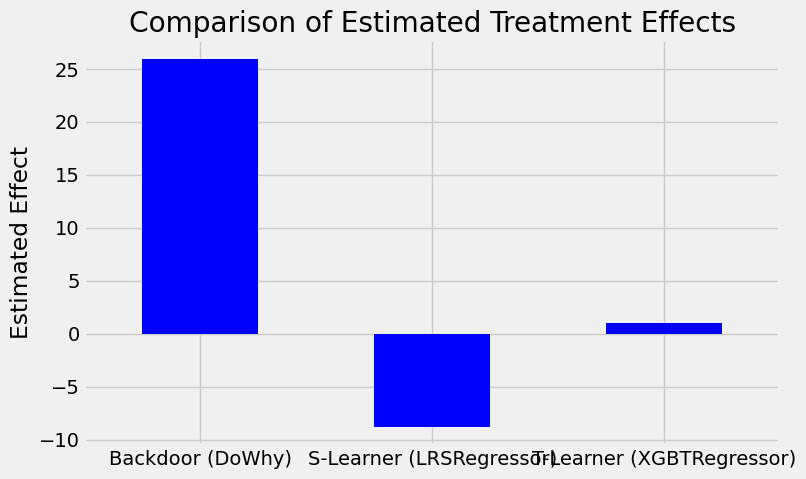

In [125]:
# Store results
treatment_effects = {
    "Backdoor (DoWhy)": 25.97,  # From previous analysis
    "S-Learner (LRSRegressor)": np.mean(treatment_effect_s),
    "T-Learner (XGBTRegressor)": np.mean(treatment_effect_t),
}

# Convert to DataFrame
import pandas as pd
df_results = pd.DataFrame.from_dict(treatment_effects, orient="index", columns=["Estimated Treatment Effect"])
print(df_results)

# Plot results
import matplotlib.pyplot as plt
df_results.plot(kind="bar", legend=False, color=["blue", "green", "red"], figsize=(8, 5))
plt.title("Comparison of Estimated Treatment Effects")
plt.ylabel("Estimated Effect")
plt.xticks(rotation=0)
plt.show()


Plot Feature Importance (T-Learner - XGBoost)

In [131]:
print(type(learner_t.models_c))  # Check type of control group models
print(type(learner_t.models_t))  # Check type of treated group models

print(learner_t.models_c.keys())  # Check available keys
print(learner_t.models_t.keys())  # Check available keys


<class 'dict'>
<class 'dict'>
dict_keys([1])
dict_keys([1])


In [132]:
xgb_model_control = learner_t.models_c[list(learner_t.models_c.keys())[0]]  # First key from dict
xgb_model_treated = learner_t.models_t[list(learner_t.models_t.keys())[0]]  # First key from dict


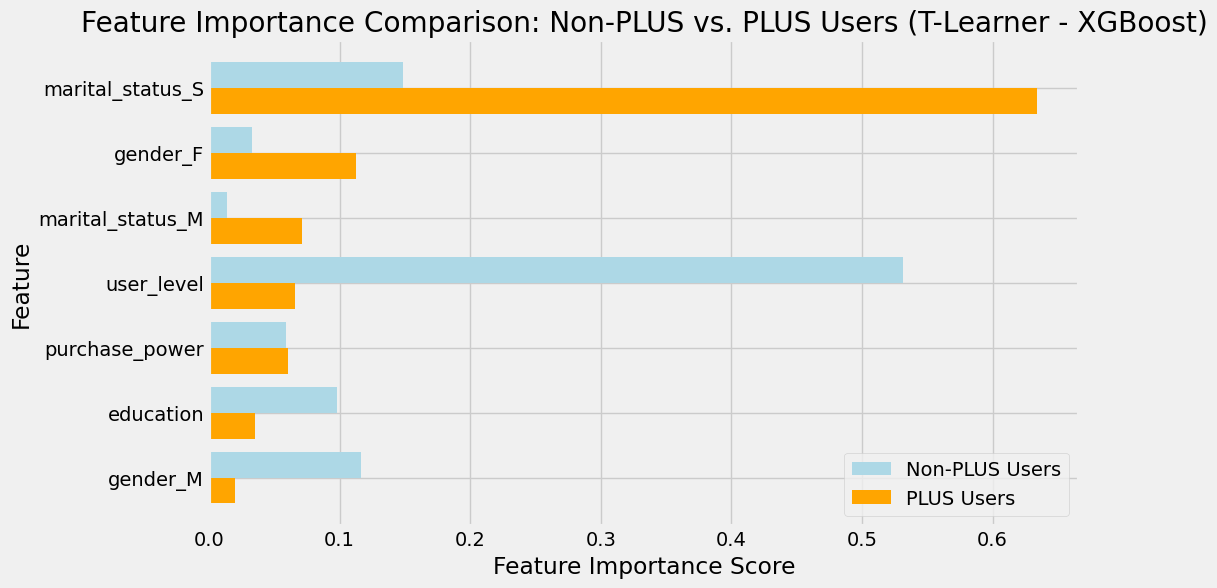

In [133]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Get feature importance
feature_importance_control = xgb_model_control.feature_importances_
feature_importance_treated = xgb_model_treated.feature_importances_

# Convert to DataFrame for easier visualization
feature_importance_df = pd.DataFrame({
    "Feature": features,
    "Control (Non-PLUS)": feature_importance_control,
    "Treated (PLUS)": feature_importance_treated
})

# Sort by importance in treated group
feature_importance_df = feature_importance_df.sort_values(by="Treated (PLUS)", ascending=False)

# Plot comparison
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.4
index = np.arange(len(feature_importance_df))

plt.barh(index, feature_importance_df["Control (Non-PLUS)"], bar_width, label="Non-PLUS Users", color="lightblue")
plt.barh(index + bar_width, feature_importance_df["Treated (PLUS)"], bar_width, label="PLUS Users", color="orange")

# Labels and formatting
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance Comparison: Non-PLUS vs. PLUS Users (T-Learner - XGBoost)")
plt.yticks(index + bar_width / 2, feature_importance_df["Feature"])
plt.legend()
plt.gca().invert_yaxis()  # Flip y-axis to show most important features on top
plt.show()


###**Interpretation:**

The feature importance chart compares how different factors influence total spending for PLUS vs. Non-PLUS users using the T-Learner (XGBoost model).

* For PLUS Users:

Marital_Status_S (Single) is the most influential factor in predicting spending.
Gender_F (Female) is also more important for PLUS users than for non-PLUS users.
Education, Purchase Power, and User Level have lower importance compared to marital status.

* For Non-PLUS Users:

User Level is the most important feature, suggesting that spending is more structured by hierarchy (loyalty tiers, past activity, etc.).
Gender_M (Male) and Education are more important than in PLUS users.
Marital Status is much less important, meaning that relationship status doesn’t strongly determine spending among non-PLUS users.

##Using DoWhy on users with at least one purchase in March

**Next Step: Analyzing users with at least one purchase**
Since our dataset only covers one month, many users **did not make any purchases during this period**, resulting in **total spending = 0** for them.  
To **properly assess the impact of PLUS membership on spending**, we performed the analysis **twice**:  
* **On the full dataset** (including users with zero
spending) to measure **the overall effect of PLUS membership, regardless of whether a user made a purchase or not**.  
* **After removing users with zero spending**, to focus only on users who made at least one purchase and analyze whether PLUS members spend more than non-members **among active shoppers**.  



By **comparing both approaches**, we can understand **whether PLUS membership influences total spending directly or simply encourages users to make more frequent purchases**.


**Using DoWhy on the dataset of users which had a purchase at least once**

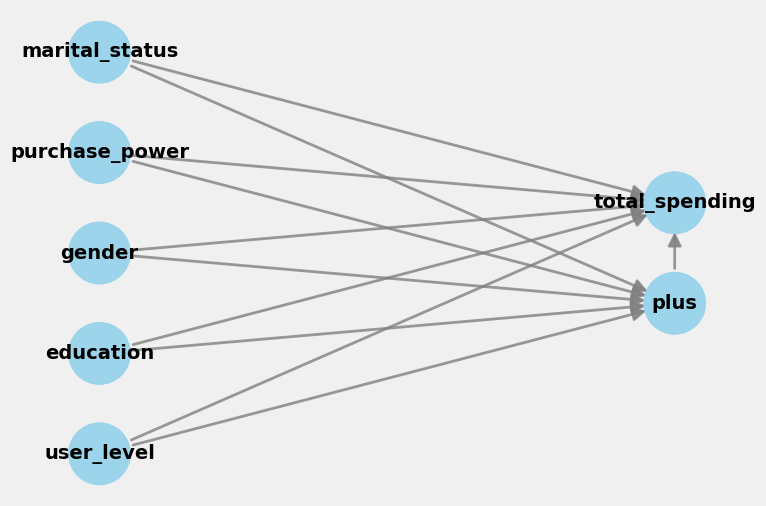

In [94]:
# Define the causal model on total spending
model = CausalModel(
    data=JD_user_level_clean,
    treatment="plus",  # Treatment variable
    outcome="total_spending",  # Outcome variable
    common_causes=["user_level", "purchase_power", "education", "gender", "marital_status"]  # Control variables
)

# View the Causal Graph Interface
model.view_model()


Since we did not find a positive effect, we will check the log transformation of the target as well.

In [95]:
#Identify the causal effect
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                                
───────(E[total_spending|user_level,education,gender,purchase_power,marital_status])
d[plus]                                                                             
Estimand assumption 1, Unconfoundedness: If U→{plus} and U→total_spending then P(total_spending|plus,user_level,education,gender,purchase_power,marital_status,U) = P(total_spending|plus,user_level,education,gender,purchase_power,marital_status)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



###**Interpretation:**
The output confirms that we can estimate the causal effect of PLUS membership on total spending using the backdoor adjustment method, meaning we control for variables like user level, education, gender, purchase power, and marital status to remove bias.

However, the model did not find valid instrumental variables (IVs) or frontdoor paths, meaning there are no external factors or mediators that could independently influence PLUS membership and spending.

This means we can proceed with estimating the causal effect using Propensity Score Matching (PSM).

In [96]:
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_matching"
)
print(f"Estimated Causal Effect: {estimate.value}")


Estimated Causal Effect: -4.016913104623064


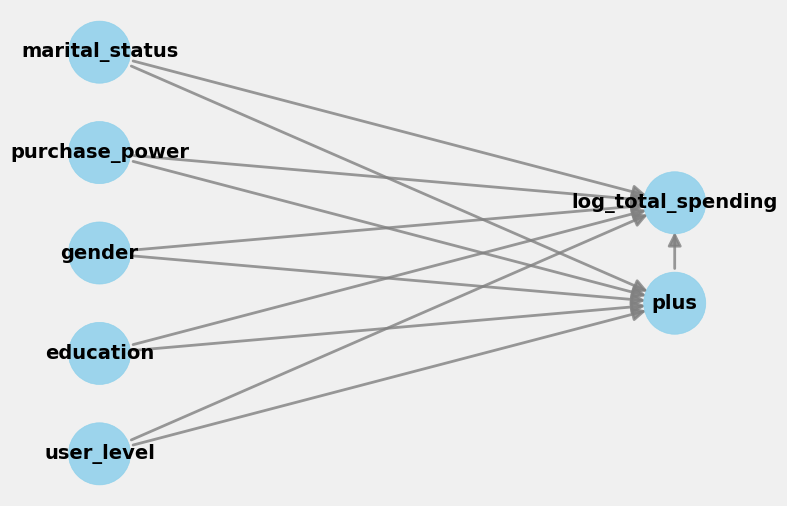

In [98]:
# Define the causal model on total spending (log)
model = CausalModel(
    data=JD_user_level_clean,
    treatment="plus",  # Treatment variable
    outcome="log_total_spending",  # Outcome variable
    common_causes=["user_level", "purchase_power", "education", "gender", "marital_status"]  # Control variables
)

# View the Causal Graph Interface
model.view_model()


In [99]:
#Identify the causal effect
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                                    
───────(E[log_total_spending|user_level,education,gender,purchase_power,marital_status])
d[plus]                                                                                 
Estimand assumption 1, Unconfoundedness: If U→{plus} and U→log_total_spending then P(log_total_spending|plus,user_level,education,gender,purchase_power,marital_status,U) = P(log_total_spending|plus,user_level,education,gender,purchase_power,marital_status)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [100]:
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_matching"
)
print(f"Estimated Causal Effect: {estimate.value}")


Estimated Causal Effect: -0.136463035233902


In [57]:
# Convert log effect back to original scale to have the decrease in total spending (%)
original_effect = np.exp(-0.136) - 1
print(f"Converted Causal Effect (Original Scale): {original_effect:.2%}")


Converted Causal Effect (Original Scale): -12.72%


###**Comparison of Estimated Causal Effects**
for total spending and log transformation of total spending


| **Outcome Variable**     | **Estimated Causal Effect** | **Interpretation** |
|-------------------------|----------------------------|--------------------|
| **Total Spending**      | **-4.02**                   | PLUS members spend 4.02 fewer units on average. |
| **Log Total Spending**  | **-0.127**                  | PLUS members spend **12.7% less** on average. |

This contradicts our hypothesis that plus users (among active users) spend more money (at least in a month)


# **Conclusion:**

### **Causal Inference Results: Effect of PLUS Membership on Spending**

| **Analysis Type** | **Estimated Causal Effect** | **Interpretation** |
|------------------|--------------------------|-------------------|
| **All Users (Including Non-Purchasers)** | **+25** | PLUS membership is associated with higher spending when considering all users, even those who didn’t purchase. |
| **Only Users Who Made a Purchase in That Month** | **Negative Effect (~ -8)** | Among active buyers, PLUS members actually spend less compared to active non-PLUS users. |

##*Possible Explanations for the Negative Effect:*

1. There might be hidden confounders (e.g., income level, shopping frequency) that were not included in the model.
If high-income shoppers tend to not subscribe to PLUS but spend more, this could bias the results.

2. This data is just for one month, so if the regular frequency of purchasing from JD.com is more than 30 month we are losing an important of data by just looking at one month.

##*Possible Explanation for the Psoitive Effect on all Users:*

PLUS users may tend to purchase in smaller baskets but with higher frequency. Since delivery costs are not an issue for them and they have access to exclusive deals, their shopping behavior might shift—they no longer wait to reach a minimum order value before making a purchase. Instead, they may place more frequent, smaller orders.

However, we cannot confirm this hypothesis with just one month of data. A more extended analysis is needed to evaluate whether PLUS members make more purchases over time and to assess the potential additional costs these smaller basket sizes may impose on JD.com’s logistics and fulfillment operations.

